In [65]:
import pandas as pd
import numpy as np
from simbad_download import fetch_object_children
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import ICRS, SkyCoord
from typing import List
from astropy.table import Table
from astropy.io import ascii

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import hdbscan

In [3]:
RA: float = 11.7980
DEC: float = 85.2440
    
COLUMNS: List[str] = ['ra', 'dec', 'parallax', 'pmra', 'pmdec']
MIN_PARALLAX: float = 0.25
MAX_PARALLAX: float = 0.75
    
CLUSTER_NAME: str = 'NGC 188'
DEGREES: int = 1

1. Normalize
2. Filter on parallax

3. Try out the hdbscan, upmask

In [4]:
sources: pd.DataFrame = pd.read_csv('./data/ngc_188/1_deg.csv', index_col=None)

In [5]:
sources.head()

,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,...,azero_gspphot,azero_gspphot_lower,azero_gspphot_upper,ag_gspphot,ag_gspphot_lower,ag_gspphot_upper,ebpminrp_gspphot,ebpminrp_gspphot_lower,ebpminrp_gspphot_upper,libname_gspphot
0,1636148068921376768,Gaia DR3 2300138708529315712,2300138708529315712,662381376,2016.0,359.985190,0.082591,85.152716,0.076308,0.230850,...,0.0162,0.0037,0.0413,0.0129,0.0029,0.033,0.0070,0.0016,0.0180,PHOENIX
1,1636148068921376768,Gaia DR3 2300141663466822400,2300141663466822400,1219913963,2016.0,359.864403,0.184853,85.159847,0.178241,0.214223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1636148068921376768,Gaia DR3 2300141667762951680,2300141667762951680,675368024,2016.0,359.912261,2.632776,85.157557,1.803413,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1636148068921376768,Gaia DR3 2300141938344743680,2300141938344743680,905723877,2016.0,359.893132,0.126966,85.175524,0.126572,0.401293,...,0.0116,0.0029,0.0301,0.0085,0.0021,0.022,0.0046,0.0011,0.0118,PHOENIX
4,1636148068921376768,Gaia DR3 2300142007064237952,2300142007064237952,365479039,2016.0,359.844342,0.623943,85.192913,0.546537,-0.602586,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


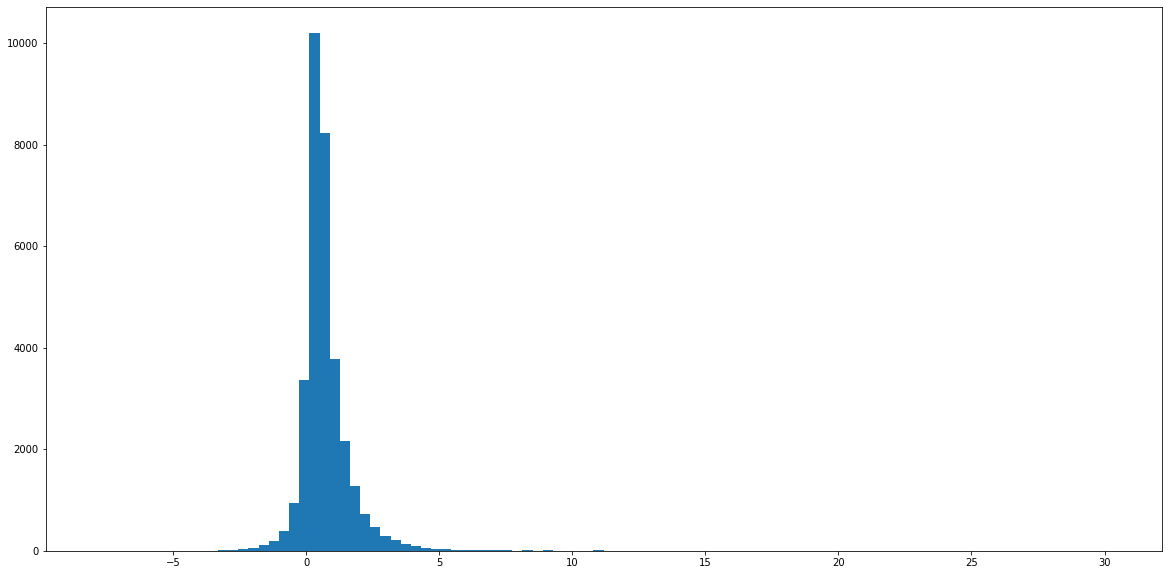

In [6]:
plt.figure(figsize=(20, 10))
plt.hist(sources.parallax, bins=100);

# Preprocessing

The NGC 188 cluster's parallax is at ~0.5 mas. I am using a broad filter of (0.25, 0.75) mas for the parallax.

In [7]:
def filter_by_parallax(sources: pd.DataFrame,
                       min_parallax: float,
                       max_parallax: float) -> pd.DataFrame:
    sources_par = sources[(sources['parallax']>min_parallax) & (sources['parallax']<max_parallax)]
    print(f'After parallax filtering: {len(sources_par)}')
    return sources_par

def clean_nans(sources: pd.DataFrame,
               columns: List[str]) -> pd.DataFrame:
    sources_clean = sources.dropna(subset=columns)
    print(f'After dropping NaNs from {columns}: {len(sources_clean)}')
    return sources_clean

def wrap_coordinates(sources: pd.DataFrame) -> pd.DataFrame:
    sources_wrapped = sources.copy()
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources['ra'].values,
                                          dec=sources['dec'].values,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    
        
    sources_wrapped.ra = sky_coords.ra.wrap_at(180 * u.deg).value
    return sources_wrapped

def normalize(sources: pd.DataFrame, columns: List[str]) -> pd.DataFrame:
    scaler = StandardScaler()
    return scaler.fit_transform(sources[columns])

def prepare_data_for_clustering(sources: pd.DataFrame,
                                min_parallax: float,
                                max_parallax: float,
                                columns: List[str]) -> pd.DataFrame:
    return wrap_coordinates(
        clean_nans(
            filter_by_parallax(sources, min_parallax, max_parallax),
            columns
        )
    )

In [8]:
sources_to_cluster = prepare_data_for_clustering(sources, MIN_PARALLAX, MAX_PARALLAX, COLUMNS)
sources_normalized = normalize(sources_to_cluster, COLUMNS)

After parallax filtering: 13684
After dropping NaNs from ['ra', 'dec', 'parallax', 'pmra', 'pmdec']: 13684


The clustering is performing using 5 astrometric parameters of $\alpha$, $\delta$, $\varpi$, $\mu_{\alpha*}$, $\mu_\delta$.

Normalization scales the features to an unit variance.

In [9]:
def plot_on_aitoff(sources: pd.DataFrame, cluster_name: str, degrees: float):
    sky_coords: List[SkyCoord] = SkyCoord(ra=sources.ra,
                                          dec=sources.dec,
                                          unit=(u.deg, u.deg),
                                          frame=ICRS)
    plt.figure(figsize=(10, 7));
    plt.subplot(111, projection="aitoff");
    plt.scatter(sky_coords.ra.radian, sky_coords.dec.radian, color='salmon',
                label=f'{cluster_name} center$\pm {degrees}^\circ$');
    plt.grid();
    plt.legend(loc='lower right', fontsize=14);

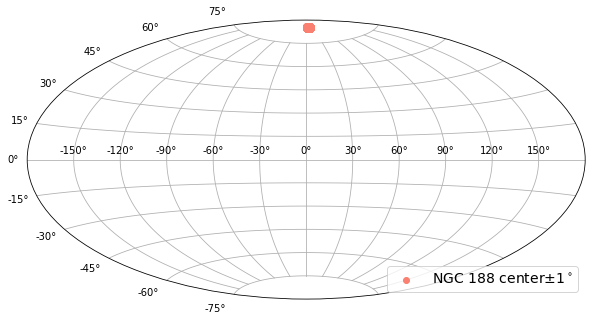

In [10]:
plot_on_aitoff(sources_to_cluster, CLUSTER_NAME, DEGREES)

# DBSCAN

In [69]:
def dbscan(sources: pd.DataFrame, eps: float = 0.5) -> np.array:
    dbscan_clust = DBSCAN(eps=eps, min_samples=20)
    dbscan_fit = dbscan_clust.fit(sources_normalized)

    dbscan_labels = dbscan_fit.labels_
    unique_labels = set(dbscan_labels)
    print(f'Classified into {len(unique_labels)} labels: {unique_labels}')
    return dbscan_labels

def label_sources(sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    sources_labelled = pd.DataFrame(columns=[*sources.columns, 'label'],
                                    data=np.concatenate([sources,
                                                         labels.reshape((-1, 1))], axis=1))
    sources_labelled['label'] = sources_labelled.label.astype(int)
    return sources_labelled

def get_clustered_and_noise(labelled_sources: pd.DataFrame, labels: np.array) -> pd.DataFrame:
    non_noise_labels: np.array = labels[labels!=-1]
    unique_label_count = np.unique(non_noise_labels, return_counts=True)
    largest_non_noise: int = unique_label_count[0][np.argmax(unique_label_count[1])]
    
    clustered: pd.DataFrame = labelled_sources[labelled_sources['label']==largest_non_noise]
    noise: pd.DataFrame = labelled_sources[labelled_sources['label']!=largest_non_noise]
        
    print(f'Clustered: {len(clustered)}/{len(labelled_sources)}')
        
    return clustered, noise

In [13]:
cluster_children: pd.DataFrame = fetch_object_children('NGC 188')

In [14]:
cluster_children.head()

,obj_id,link_bibcode,ra,dec
0,NGC 188 1054,2004PASP..116.1012S,11.191250,85.256734
1,Cl* NGC 188 DGV 1869,2004PASP..116.1012S,9.743203,85.559916
2,NGC 188 2014,2004PASP..116.1012S,10.977598,85.205113
3,NGC 188 1152,2004PASP..116.1012S,11.164145,85.242850
4,NGC 188 3129,2004PASP..116.1012S,11.151445,85.352770


In [15]:
def is_in_cluster(source: np.array, cluster_coords: np.array) -> bool:
    return (np.any(np.isclose(source[0], cluster_coords[:, 0].astype(np.float32), rtol=1e-4)) and
            np.any(np.isclose(source[1], cluster_coords[:, 1].astype(np.float32), rtol=1e-4)))

In [16]:
def check_for_cluster_children(cluster_children: pd.DataFrame,
                               sources_cluster: pd.DataFrame) -> bool:
    cluster_children_coords = np.unique(cluster_children.values[:, [2, 3]].astype(float), axis=0)
    sources_coords = sources_cluster[['ra', 'dec']].values
    
    in_cluster = np.array(list(map(lambda x: is_in_cluster(x, sources_coords), cluster_children_coords)))
    trues = in_cluster[in_cluster]
    print(f'{len(trues)}/{len(in_cluster)} objects found in the cluster.')
    return len(trues)/len(in_cluster)

def check_for_undiscovered_sources(cluster_children: pd.DataFrame,
                                   sources_cluster: pd.DataFrame) -> bool:
    cluster_children_coords = np.unique(cluster_children.values[:, [2, 3]].astype(float), axis=0)
    sources_coords = sources_cluster[['ra', 'dec']].values
    
    in_cluster = np.array(list(map(lambda x: is_in_cluster(x, cluster_children_coords), sources_coords)))
    falses = in_cluster[~in_cluster]
    print(f'Found {len(falses)} objects found in the cluster unreported in papers.')
    return len(falses)

In [17]:
labels = dbscan(sources_normalized, eps=0.455)
labelled_sources = label_sources(sources_to_cluster, labels)
clustered, noise = get_clustered_and_noise(labelled_sources, labels)

r = check_for_cluster_children(cluster_children, clustered)
undiscovered = check_for_undiscovered_sources(cluster_children, clustered)

Classified into 10 labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
152
Clustered: 1570/13684
1307/1624 objects found in the cluster.
Found 229 objects found in the cluster unreported in papers.


In [18]:
def cluster_plot(clustered_sources: pd.DataFrame,
                 noise_sources: pd.DataFrame,
                 paper_sources: pd.DataFrame):
    plt.figure(figsize=(20, 10))
    plt.scatter(clustered_sources.ra, clustered_sources.dec, color='cornflowerblue', label='Clustered', zorder=2, s=10.)
    plt.scatter(noise_sources.ra, noise_sources.dec, color='salmon', label='Unclustered', zorder=1, s=5.)
    plt.scatter(paper_sources.ra, paper_sources.dec, color='black', zorder=1,
                marker='D', label='Reported in papers')
    lgnd = plt.legend(fontsize=14);
    plt.gca().set_xlabel('$\\alpha$ [deg]', fontsize=20);
    plt.gca().set_ylabel('$\delta$ [deg]', fontsize=20);

    for handle in lgnd.legendHandles:
        handle._sizes = [30];

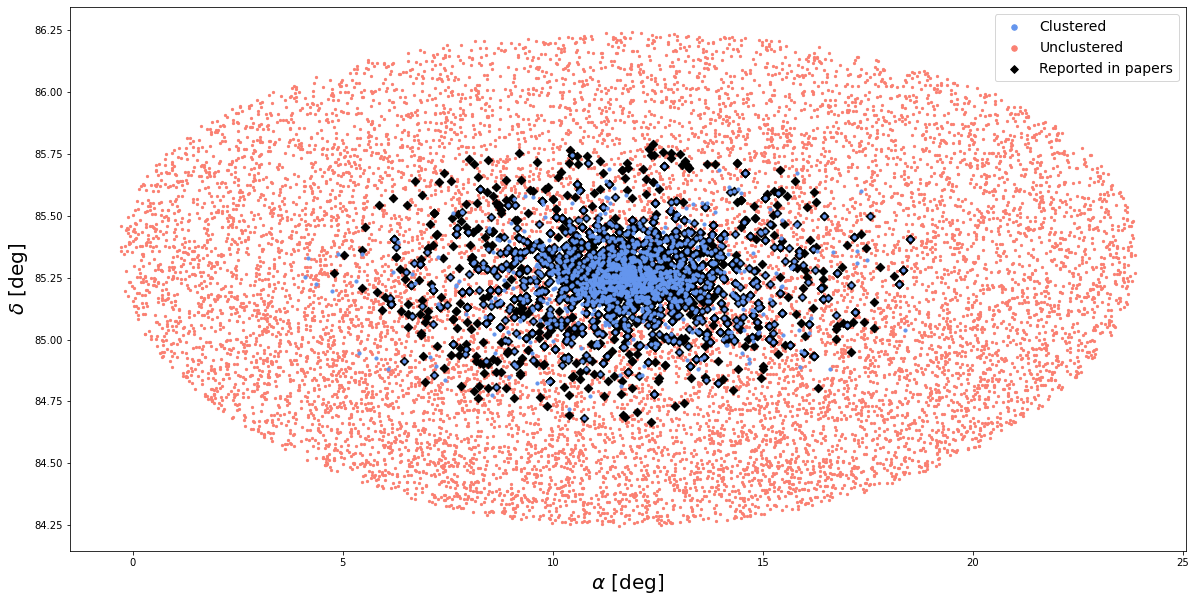

In [19]:
cluster_plot(clustered, noise, cluster_children)

In [20]:
def absolute_magnitude(g_mean_mag: np.float32,
                       parallax: np.float32) -> np.float32:
    return g_mean_mag+5*np.log10(parallax)-10

clustered['color'] = clustered.phot_bp_mean_mag-clustered.phot_rp_mean_mag
clustered['absolute_magnitude'] = absolute_magnitude(clustered.phot_g_mean_mag,
                                                     clustered.parallax.values.astype(np.float32))

<ipython-input-20-fe98503ace40>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered['color'] = clustered.phot_bp_mean_mag-clustered.phot_rp_mean_mag
<ipython-input-20-fe98503ace40>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered['absolute_magnitude'] = absolute_magnitude(clustered.phot_g_mean_mag,


In [21]:
def plot_hr(sources: pd.DataFrame):
    plt.figure(figsize=(10, 10))
    plt.scatter(sources.color, sources.absolute_magnitude,
                s=10., color='mediumvioletred', marker='*')
    plt.gca().invert_yaxis()
    plt.gca().set_xlabel('B-R [mag]', fontsize=14);
    plt.gca().set_ylabel('absolute magnitude [mag]', fontsize=14);

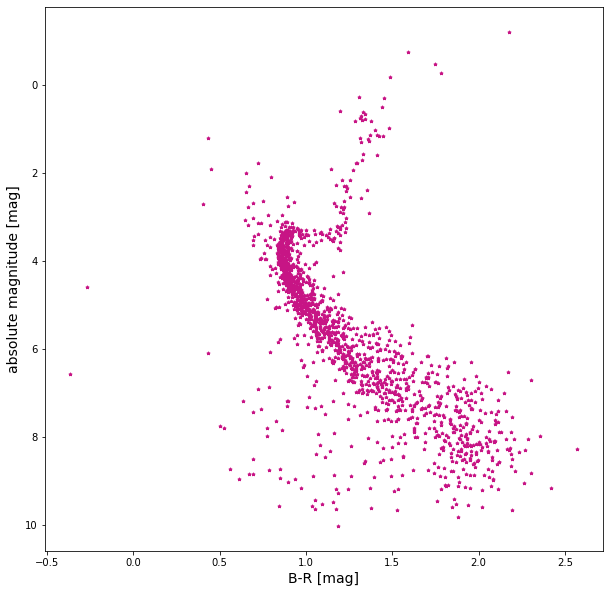

In [22]:
plot_hr(clustered)

In [23]:
blue_stragglers = clustered[((clustered.absolute_magnitude<3) & (clustered.color<1.0)) |
                            ((clustered.absolute_magnitude<3.75) & (clustered.color<0.8))]

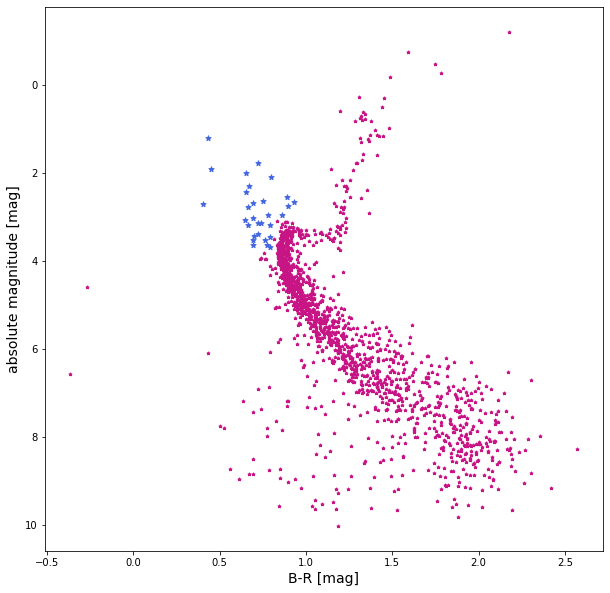

In [24]:
plot_hr(clustered)
plt.scatter(blue_stragglers.color, blue_stragglers.absolute_magnitude,
            s=30., color='royalblue', marker='*');

In [25]:
data = Table()
data['_x'] = sources_normalized[:, 0]
data['_y'] = sources_normalized[:, 1]
data['Plx'] = sources_normalized[:, 2]
data['pmRA'] = sources_normalized[:, 3]
data['pmDE'] = sources_normalized[:, 4]
ascii.write(data, 'pyUPMASK/input/ngc_188.dat', overwrite=True) 

# pyUPMASK

In [36]:
pyupmask_clustered = ascii.read('pyUPMASK/output/ngc_188.dat').to_pandas()

In [47]:
len(pyupmask_clustered[pyupmask_clustered.probs_final>0.9])

1529

In [63]:
CLUSTER_THRESHOLD: float = 0.75
labels_pyupmask = (pyupmask_clustered.probs_final>CLUSTER_THRESHOLD).astype(int).values-1
    
labelled_sources_pyupmask = label_sources(sources_to_cluster,
                                          labels_pyupmask)
clustered_pyupmask, noise_pyupmask = get_clustered_and_noise(labelled_sources_pyupmask,
                                                             labels_pyupmask)

r = check_for_cluster_children(cluster_children, clustered_pyupmask)
undiscovered = check_for_undiscovered_sources(cluster_children, clustered_pyupmask)

152
0
Clustered: 1908/13684
1325/1624 objects found in the cluster.
Found 455 objects found in the cluster unreported in papers.


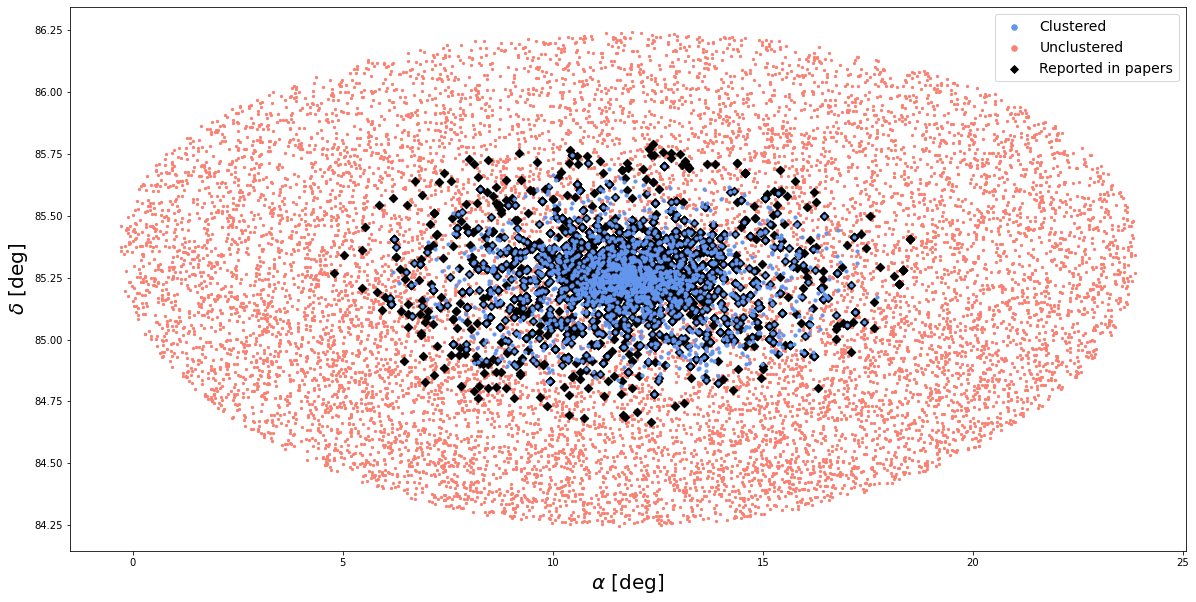

In [64]:
cluster_plot(clustered_pyupmask, noise_pyupmask, cluster_children)

# HDBSCAN

In [75]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=20, allow_single_cluster=True)

In [76]:
labels_hdbscan = clusterer.fit_predict(sources_normalized)
labelled_sources_hdbscan = label_sources(sources_to_cluster, labels_hdbscan)
clustered_hdbscan, noise_hdbscan = get_clustered_and_noise(labelled_sources_hdbscan, labels_hdbscan)

r = check_for_cluster_children(cluster_children, clustered_hdbscan)
undiscovered = check_for_undiscovered_sources(cluster_children, clustered_hdbscan)

Clustered: 1488/13684
1240/1624 objects found in the cluster.
Found 254 objects found in the cluster unreported in papers.


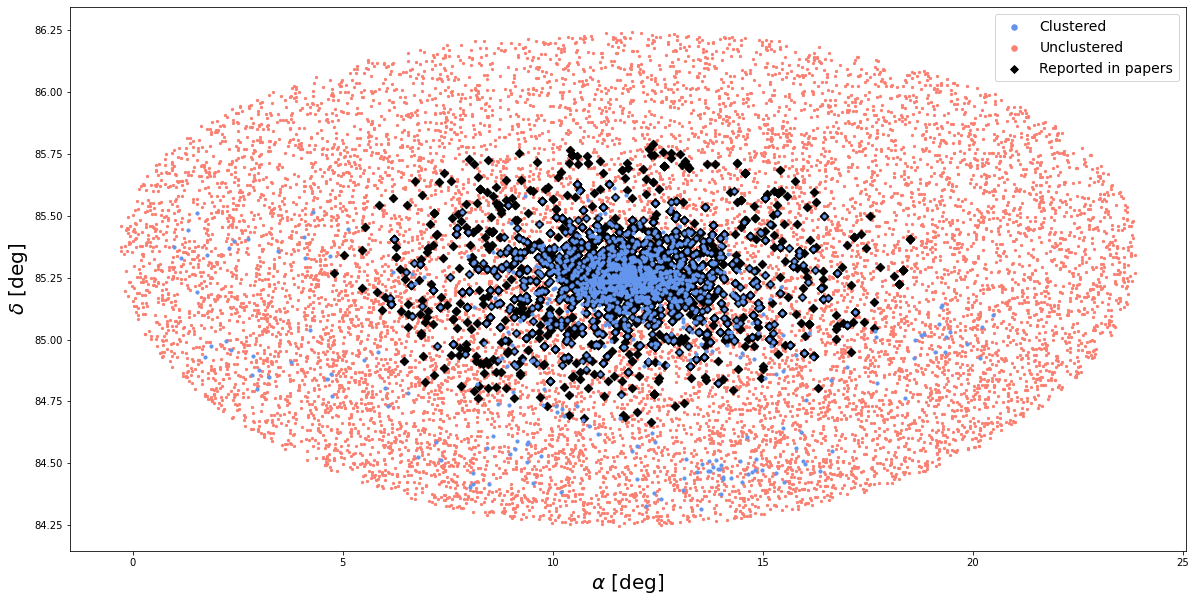

In [77]:
cluster_plot(clustered_hdbscan, noise_hdbscan, cluster_children)